In [1]:
%pylab inline
from scipy.sparse import csr_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
%cd /data/home/vadim/topics/msr2017/

/data/home/vadim/topics/msr2017


In [4]:
words = []
csr_data = []
csr_indices = []
csr_indptr = [0]
with open("decorr_readable.txt") as fin:
    fin.readline()
    for line in fin:
        parts = line[:-1].split(";")
        words.append(parts[0])
        for i, p in enumerate(parts[2:]):
            if p != "0":
                csr_data.append(float(p))
                csr_indices.append(i)
        csr_indptr.append(len(csr_data))

In [5]:
topics = csr_matrix((csr_data, csr_indices, csr_indptr), shape=(len(words), 320)).astype(float32)
del csr_data, csr_indices, csr_indptr

In [7]:
topics

<2015336x320 sparse matrix of type '<class 'numpy.float32'>'
	with 16892389 stored elements in Compressed Sparse Row format>

In [10]:
word_index = {w: i for i, w in enumerate(words)}

In [11]:
repos = []
csr_data = []
csr_indices = []
csr_indptr = [0]
with open("../dataset.txt") as fin:
    for line in fin:
        parts = line[:-1].split(" ")
        repos.append(parts[0])
        for p in parts[1:]:
            n, v = p.split(":")
            csr_data.append(float(v))
            csr_indices.append(word_index[n])
        csr_indptr.append(len(csr_data))
reposm = csr_matrix((csr_data, csr_indices, csr_indptr), shape=(len(repos), len(words))).astype(float32)
del csr_data, csr_indices, csr_indptr

In [12]:
reposm

<8003694x2015336 sparse matrix of type '<class 'numpy.float32'>'
	with 2279944597 stored elements in Compressed Sparse Row format>

In [14]:
bag_sizes = (reposm > 0).sum(axis=1)

In [15]:
bag_sizes.shape

(8003694, 1)

In [16]:
(bag_sizes >= 50).sum()

6222836

In [23]:
filtered = squeeze(asarray(bag_sizes >= 50))

In [24]:
repos = array(repos)[filtered]

In [26]:
reposm = reposm[filtered]

In [27]:
reposm

<6222836x2015336 sparse matrix of type '<class 'numpy.float32'>'
	with 2231917551 stored elements in Compressed Sparse Row format>

In [28]:
%time repost = reposm.dot(topics)

CPU times: user 19min 42s, sys: 36.8 s, total: 20min 19s
Wall time: 20min 22s


In [29]:
repost.shape

(6222836, 320)

In [31]:
type(repost)

scipy.sparse.csr.csr_matrix

In [32]:
repost = repost.todense()

In [34]:
(repost[0]*repost[0].T).sum()

39.900505

In [35]:
repost /= linalg.norm(repost, axis=1)[:, newaxis]

In [36]:
(repost[0]*repost[0].T).sum()

0.99999994

In [38]:
repost.mean(), repost.std()

(0.03414505, 0.044261999)

In [39]:
import pickle 
with open("repost_decorr.pickle", "wb") as fout:
    pickle.dump((repos, repost), fout, protocol=-1)

In [113]:
with open("repost_decorr.pickle", "rb") as fin:
    _, repost = pickle.load(fin)

In [114]:
repost[repost < (repost.mean() + repost.std() * 2)] = 0

In [115]:
repost = csr_matrix(repost)

In [43]:
repost

<6222836x320 sparse matrix of type '<class 'numpy.float32'>'
	with 62106752 stored elements in Compressed Sparse Row format>

In [44]:
62106752 / (6222836 * 320)

0.031188930577633736

In [106]:
from scipy.sparse import diags
repost_normed = diags([1/sqrt(squeeze(asarray(repost.multiply(repost).sum(axis=1))))], [0], format="csr").dot(repost)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


this warning is OK because kmcuda is robust to NaN-s in input

In [110]:
repost_normed[1, :].multiply(repost_normed[1, :]).sum()

0.99999982

In [112]:
repost_normed

<6222836x320 sparse matrix of type '<class 'numpy.float32'>'
	with 62106752 stored elements in Compressed Sparse Row format>

In [111]:
with open("repost_decorr_sparse.pickle", "wb") as fout:
    pickle.dump((repos, repost_normed), fout, protocol=-1)

In [116]:
del repost, repost_normed

In [117]:
with open("cluster.py", "w") as fout:
    fout.write("""import pickle, libKMCUDA
with open("repost_decorr_sparse.pickle", "rb") as fin:
    _, repost = pickle.load(fin)
repost = repost.todense()
dists = []
for k in range(100, 5100, 100):
    _, _, average_distance = libKMCUDA.kmeans_cuda(
        repost, k, yinyang_t=0, metric="angular", verbosity=1, seed=777, average_distance=True)
    print("Average distance:", average_distance)
    dists.append(average_distance)
with open("distances.pickle", "wb") as fout:
    pickle.dump(dists, fout, protocol=-1)
""")

In [ ]:
!python3 cluster.py

reassignments threshold: 62228
transposing the samples...
performing kmeans++...
done            
too few clusters for this yinyang_t => Lloyd
iteration 1: 6222836 reassignments
iteration 2: 1794373 reassignments
iteration 3: 757318 reassignments
iteration 4: 422121 reassignments
iteration 5: 269110 reassignments
iteration 6: 185854 reassignments
iteration 7: 133804 reassignments
iteration 8: 106920 reassignments
iteration 9: 97963 reassignments
iteration 10: 91203 reassignments
iteration 11: 71240 reassignments
iteration 12: 49112 reassignments
calculating the average distance...
Average distance: 0.6130881905555725
reassignments threshold: 62228
p2p is already enabled on gpu #0
p2p is already enabled on gpu #1
transposing the samples...
performing kmeans++...
done            
too few clusters for this yinyang_t => Lloyd
iteration 1: 6222836 reassignments
iteration 2: 1852626 reassignments
iteration 3: 807923 reassignments
iteration 4: 460337 reassignments
iteration 5: 304493 reassign

In [119]:
with open("distances.pickle", "rb") as fin:
    dists = pickle.load(fin)

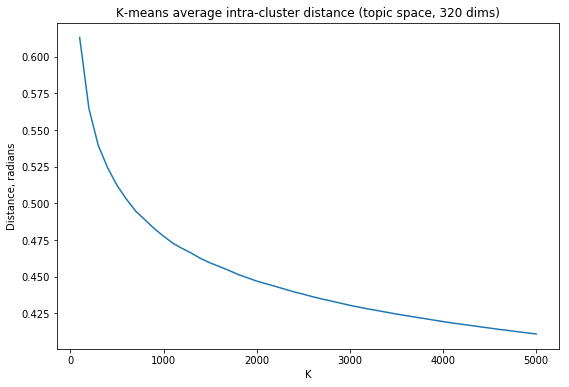

In [120]:
rcParams["figure.figsize"] = (9, 6)
plot(arange(100, 5100, 100), dists)
title("K-means average intra-cluster distance (topic space, 320 dims)")
xlabel("K")
ylabel("Distance, radians")

In [65]:
# the best K value
K = 3000

In [121]:
with open("cluster.py", "w") as fout:
    fout.write("""import pickle, libKMCUDA
with open("repost_decorr_sparse.pickle", "rb") as fin:
    _, repost = pickle.load(fin)
repost = repost.todense()
dists = []
centroids, assignments = libKMCUDA.kmeans_cuda(
        repost, 3000, metric="angular", verbosity=2, seed=777, tolerance=0.001)
    
with open("topic_clusters_320_decorr.pickle", "wb") as fout:
    pickle.dump((centroids, assignments), fout, protocol=-1)
""")

In [ ]:
!python3 cluster.py

arguments: 1 0x7ffe5d8dae44 0.001 0.10 1 6222836 320 3000 777 0 0 2 0x7f7515d84010 0x2e9b170 0x3244980 (nil)
reassignments threshold: 6222
yinyang groups: 300
reusing passed_yy for centroids_yy
GPU #0 memory: used 11948523520 bytes (93.5%), free 833028096 bytes, total 12781551616 bytes
GPU #1 memory: used 11948523520 bytes (93.5%), free 833028096 bytes, total 12781551616 bytes
GPU #0 has 49152 bytes of shared memory per block
GPU #1 has 49152 bytes of shared memory per block
transposing the samples...
transpose <<<(194464, 10), (8, 32)>>> 6222836, 320, xyswap
performing kmeans++...
done            
running Lloyd until reassignments drop below 684511
plans: [(0, 3111418), (3111418, 3111418)]
planc: [(0, 1500), (1500, 1500)]
iteration 1: 6222836 reassignments
iteration 2: 2015543 reassignments
iteration 3: 978745 reassignments
iteration 4: 609695 reassignments
transposing the samples...
transpose <<<(94, 10), (8, 32)>>> 3000, 320, xyswap
performing kmeans++...
done            
plans: [(0

In [123]:
with open("topic_clusters_320_decorr.pickle", "rb") as fin:
    centroids, assignments = pickle.load(fin)

In [72]:
from sklearn.manifold import TSNE

In [124]:
# NaN centroids which were suppressed by surroundings
(centroids[:, 0] != centroids[:, 0]).sum()

2

In [125]:
centroids_fixed = centroids[~isnan(centroids).any(axis=1)]

In [126]:
def angular_distance(x, y):
    return arccos(min(x.dot(y), 1))

from sklearn.metrics.pairwise import pairwise_distances
cdists = pairwise_distances(centroids_fixed, centroids_fixed, metric=angular_distance)

In [127]:
model = TSNE(random_state=777, metric="precomputed", n_iter=5000)
embeddings = model.fit_transform(cdists)

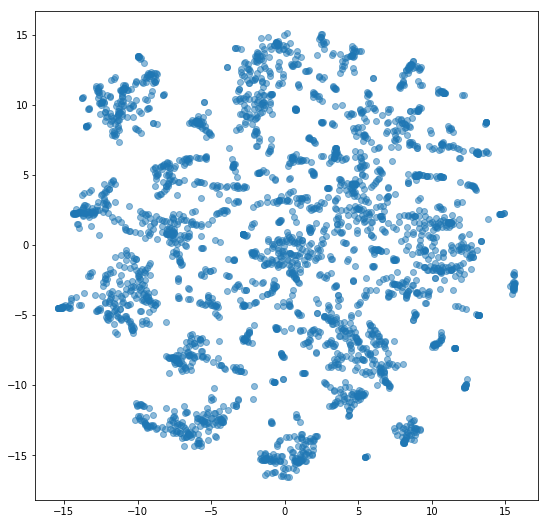

In [128]:
rcParams["figure.figsize"] = (9, 9)
scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.5)

In [130]:
sqrt(3000)

54.772255750516614

In [131]:
54 * 54

2916

In [132]:
with open("cluster.py", "w") as fout:
    fout.write("""import pickle, libKMCUDA
with open("repost_decorr_sparse.pickle", "rb") as fin:
    _, repost = pickle.load(fin)
repost = repost.todense()
dists = []
centroids, assignments = libKMCUDA.kmeans_cuda(
        repost, 2916 + 2, metric="angular", verbosity=2, seed=777, tolerance=0.001)
    
with open("topic_clusters_320_decorr.pickle", "wb") as fout:
    pickle.dump((centroids, assignments), fout, protocol=-1)
""")

In [133]:
%time !python3 cluster.py

arguments: 1 0x7fffc81fa974 0.001 0.10 1 6222836 320 2918 777 0 0 2 0x7fcea42d8010 0x2ecb180 0x325af90 (nil)
reassignments threshold: 6222
yinyang groups: 291
reusing passed_yy for centroids_yy
GPU #0 memory: used 11835277312 bytes (92.6%), free 946274304 bytes, total 12781551616 bytes
GPU #1 memory: used 11835277312 bytes (92.6%), free 946274304 bytes, total 12781551616 bytes
GPU #0 has 49152 bytes of shared memory per block
GPU #1 has 49152 bytes of shared memory per block
transposing the samples...
transpose <<<(194464, 10), (8, 32)>>> 6222836, 320, xyswap
performing kmeans++...
done            
running Lloyd until reassignments drop below 684511
plans: [(0, 3111418), (3111418, 3111418)]
planc: [(0, 1460), (1460, 1458)]
iteration 1: 6222836 reassignments
iteration 2: 2019922 reassignments
iteration 3: 980582 reassignments
iteration 4: 612683 reassignments
transposing the samples...
transpose <<<(92, 10), (8, 32)>>> 2918, 320, xyswap
performing kmeans++...
done            
plans: [(0

In [134]:
with open("topic_clusters_320_decorr.pickle", "rb") as fin:
    centroids, assignments = pickle.load(fin)
(centroids[:, 0] != centroids[:, 0]).sum()

2

In [135]:
centroids_fixed = centroids[~isnan(centroids).any(axis=1)]

In [136]:
centroids_fixed.shape

(2916, 320)

In [137]:
cdists = pairwise_distances(centroids_fixed, centroids_fixed, metric=angular_distance)
model = TSNE(random_state=777, metric="precomputed", n_iter=5000)
embeddings = model.fit_transform(cdists)

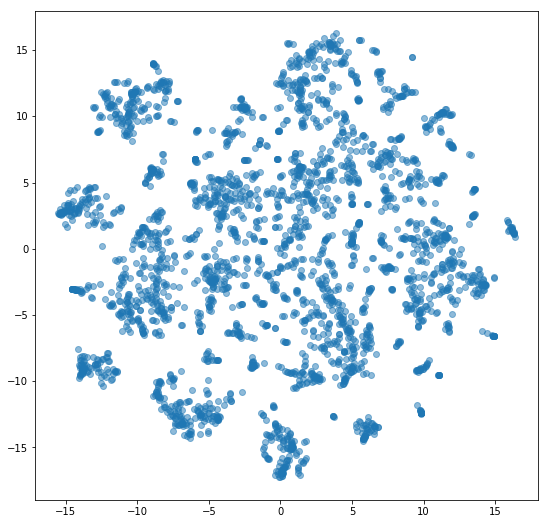

In [138]:
scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.5)

In [148]:
import lapjv
from scipy.spatial.distance import cdist

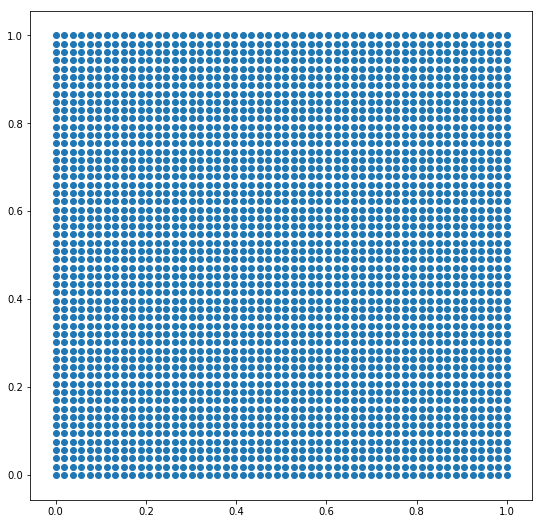

In [150]:
grid = dstack(meshgrid(linspace(0, 1, 54), linspace(0, 1, 54))).reshape(-1, 2)
scatter(grid[:,0], grid[:,1])

In [151]:
embeddings -= embeddings.min(axis=0)
embeddings /= embeddings.max(axis=0)
cost_matrix_topics = cdist(grid, embeddings, "sqeuclidean").astype(float32)
cost_matrix_topics = cost_matrix_topics * (100000 / cost_matrix_topics.max())
cmt_sorted = cost_matrix_topics.flatten()
cmt_sorted.sort()
cmt_diff = diff(cmt_sorted)
cmt_diff.min(), cmt_diff.max()

(0.0, 644.89844)

In [162]:
%time row_assigns_topics, col_assigns_topics, _ = lapjv.lapjv(cost_matrix_topics)

CPU times: user 9.87 s, sys: 238 ms, total: 10.1 s
Wall time: 10.1 s


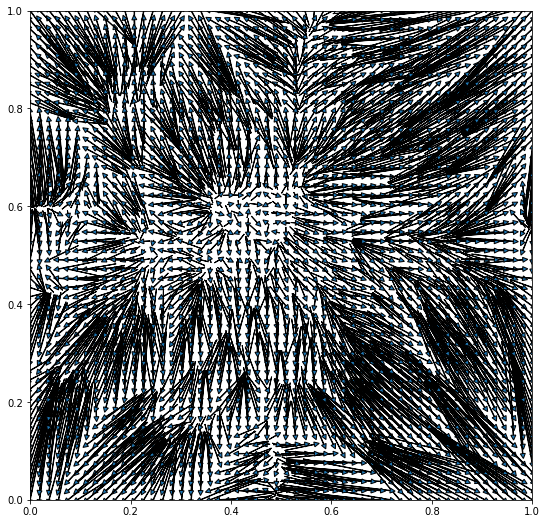

In [163]:
grid_jv = grid[col_assigns_topics]
for start, end in zip(embeddings, grid_jv):
    arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
          head_length=0.01, head_width=0.01)

In [167]:
%cd ..

/data/home/vadim/topics


In [170]:
!rm bigartm.*

In [172]:
with open("devs.pickle", "rb") as fin:
    devs = pickle.load(fin)

In [176]:
len(devs)

6621684

In [177]:
for dev in devs:
    if "mcuadros@gmail.com" in dev[0][1]:
        maximos_repos = dev[1]
        break

In [184]:
maximos_repos

[('gregjones/httpcache', 0.011235955056179775),
 ('bobappleyard/readline', 0.022727272727272728),
 ('stretchr/objx', 0.008130081300813009),
 ('stephens2424/php', 0.0024096385542168677),
 ('golang/gddo', 0.016666666666666666),
 ('fsouza/go-dockerclient', 0.004633204633204633),
 ('stevedomin/termtable', 0.06666666666666667),
 ('spf13/cobra', 0.0024937655860349127),
 ('cheggaaa/pb', 0.011235955056179775),
 ('mcuadros/go-syslog', 0.32857142857142857),
 ('skeetr/skeetrd', 1.0),
 ('mcuadros/go-command', 1.0),
 ('mcuadros/go-defaults', 0.8518518518518519),
 ('sourcegraph/go-vcsurl', 0.05555555555555555),
 ('mcuadros/go-version', 0.9565217391304348),
 ('level3php/mongator', 0.7622950819672131),
 ('level3php/silex', 0.8636363636363636),
 ('jdesrosiers/silex-cors-provider', 0.06382978723404255),
 ('level3php/demo', 1.0),
 ('jimbojsb/bstools', 0.06),
 ('level3php/behat', 0.9),
 ('level3php/level3', 0.6666666666666666),
 ('mcuadros/cli-array-editor', 1.0),
 ('mcuadros/php-cayley', 1.0),
 ('mongofi

In [185]:
repo_index = {r: i for i, r in enumerate(repos)}

In [186]:
maximos_repos = [(repo_index[r[0]], r[1]) for r in maximos_repos if r[0] in repo_index]

In [188]:
len(maximos_repos)

105

In [204]:
maximos_clusters = [(assignments[r[0]], r[1]) for r in maximos_repos]

In [205]:
from itertools import groupby
maximos_clusters = [[k, sum(c[1] for c in g)] for k, g in groupby(sorted(maximos_clusters), lambda c: c[0])]

In [200]:
len(maximos_clusters)

69

In [203]:
where(isnan(centroids).any(axis=1))

(array([1414, 1742]),)

In [206]:
for c in maximos_clusters:
    if c[0] > 1742:
        c[0] -= 2
    elif c[0] > 1414:
        c[0] -= 1

In [211]:
profile = zeros((54, 54), dtype=float32)
for c in maximos_clusters:
    profile[tuple((grid_jv[c[0]] * (54 - 1)).astype(int))] = c[1]

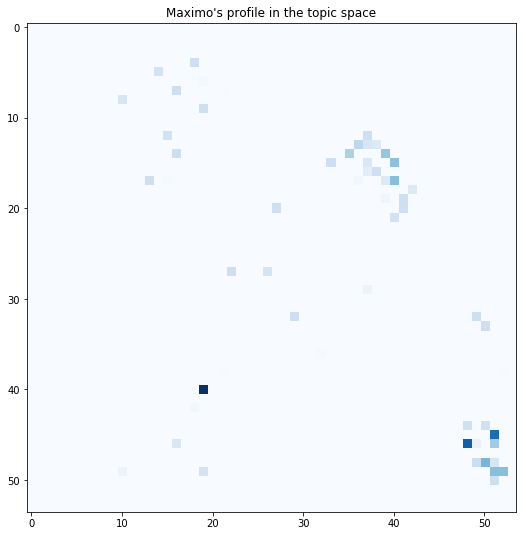

In [223]:
imshow(profile, interpolation="nearest", cmap="Blues")
title("Maximo's profile in the topic space")

In [216]:
maximos_clusters_inv = [(p[1], p[0]) for p in maximos_clusters]
maximos_clusters_inv.sort(reverse=True)

In [217]:
maximos_clusters_inv[:10]

[(4.734848484848484, 1336),
 (3.875, 827),
 (3.63905325443787, 2074),
 (2.2021507037683667, 1801),
 (2.0046332046332047, 263),
 (2.0, 2112),
 (2.0, 439),
 (1.967741935483871, 2068),
 (1.8636363636363638, 2397),
 (1.6926829268292682, 2575)]

In [218]:
for r in maximos_repos:
    if assignments[r[0]] == 1336:
        print(repos[r[0]])

skeetr/skeetrd
tyba/beanstool
src-d/fsbench
mcuadros/ofelia
mcuadros/gce-docker


### Pure Go

In [219]:
for r in maximos_repos:
    if assignments[r[0]] == 827:
        print(repos[r[0]])

mcuadros/go-jsonschema-generator
mcuadros/go-candyjs
mcuadros/go-etcd-hydrator
mcuadros/go-lookup


### Go with Javascript flavor

In [222]:
for r in maximos_repos:
    if assignments[r[0]] == 2074 + 2:
        print(repos[r[0]])

mcuadros/go-rat
mcuadros/go-raa
mcuadros/go-crxmake
src-d/go-git


### Go + low-level byte operation, packages and archives